Exploring the diversity of brain shapes in Python
====================================
Simon Homoelle, Katja Heuer, Julien Lefèvre, Anastasia Osoianu, Roberto Toro

### Summary
Brain Catalogue (braincatalogue.org) is an open­access collection of high­quality MRIs of vertebrate brains. The aim of this project is to create an ipython notebook for manipulating surface meshes that can easily be used by everyone who wants to study neuroanatomical diversity using Brain Catalogue. The notebook should be easily modifiable to analyse other datasets as well.


### Background
Brain Catalogue is a project developed by Roberto Toro from the Institut Pasteur in collaboration with the National Museum of Natural History of Paris and the Institute of the Brain and the Spinal Cord. All MRIs and surface meshes can be easily downloaded and used for studying comparative neuroanatomy.
To understand human neuroanatomical diversity within the wider landscape of mammalian neuroanatomical diversity it is important to investigate both the common traits that all mammalian brains share, as well as those that make species unique. Here we particularly focus our attention on analyses and visualization of cortical morphology which is an important neuroanatomical phenotype related to the brain evolution.


### Measurements

#### Total surface area, $S$
The total surface area of the brain is approximated by the sum of the surface area of each triangle of its surface reconstruction:

\begin{equation}
S=\sum_{i=1}^{N_t}{A(T_i)},
\end{equation}

where $A(T_i)$ is the surface area of the $i$-th triangle.

#### Total volume, $V$
The volume of the reconstruction, computed for example using the sum of the signed volume of each triangle in the reconstruction:

\begin{equation}
V=\frac 1 6 \sum_{i=1}^{N_t}{det(P(T_i))}
\end{equation}

where $det(P(T_i))/6$ is the signed volume of the tetrahedron formed by the vertices of the $i$-th triangle and the origin of the coordinates system.

#### Absolute folding, $F$
We can obtain a first global index of folding from these two values, that we call the absolute folding index, $F$. We define absolute folding as the ratio between the total surface area of the reconstruction, $S$, and $S_{sphere}$, the surface of a sphere with the same volume of the reconstruction, $V$:

\begin{equation}
F=\frac S {S_\text{sphere}},
\end{equation}

because

\begin{equation}
S_\text{sphere}=(36 \pi)^{1/3} V^{2/3},
\end{equation}

then

\begin{equation}
F=\frac {S} {(36 \pi)^{1/3} V^{2/3}}.
\end{equation}

Several researchers have defined similar indices of global folding where the total surface area $S$ is divided by the surface of a smooth envelope of the reconstruction. In those cases, the index obtained will depend on the method used to compute that smooth envelope, a convex hull for example. But because different brains will have different smooth envelopes, the baseline for comparison will change each time. In our case, the surface of the sphere with the same volume of the reconstruction is the smallest possible surface for that volume, which provides an absolute measurement of the degree of folding. 

## Here we go!

In [1]:
#We first collect the surface reconstructions. 
#The reconstruction is a list of vertices and a list of triangles constructed from these vertices. 
#The topology of the reconstruction is that of a sphere. 
#We first read the number of vertices, the number of triangles, 
#and then the list of vertices and the list of triangles.


# Achtung! Problem! it doesn't save vertices and faces of the specie, 
# so each time you run function on a new specie - you will get a new set of vertices and faces and loose the previous

In [1]:
%matplotlib inline

In [2]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
import urllib2 as url
import re
import numpy as np
import pandas as pd

In [3]:
# information that's going to be saved later in a csv - table

nt_species = [] # number of triangles
nv_species = [] # number of vertices
ne_species = [] # number of edges
S_species = [] # Surface area
V_species = [] # Volume
F_species = [] # Absolute folding
X_species = [] # size of the brain on X, Y and Z axes
Y_species = []
Z_species = []
species = []

In [4]:
def measurements(specie):
    species.append(specie)

#    mesh_url="file:///Users/ghfc/Documents/Dropbox/hugo_is_dead/scripts/BrainCatalogueWorkflow/meshes_centered/%s/both.ply" % (specie)
    mesh_url="http://braincatalogue.org/data/%s/mesh.ply" % (specie) # or as a link
    response=url.urlopen(mesh_url)
    text=response.read()
    text=text.split("\n")

    parser=re.compile("\d+")
    for line in text:
        if "element vertex" in line:
            nv=int(parser.findall(line)[0]) # number of vertices
        if "element face" in line:
            nt=int(parser.findall(line)[0]) # number of triangles
        if "end_header" in line:
            off=text.index(line)+1
            break

    # vertices
    p=np.asarray([])
    for i in range(off,off+nv):
        p=np.concatenate([p,np.fromstring(text[i],dtype=float,sep=" ")])
    p=p.reshape(nv,3)

    # triangles
    t=np.asarray([])
    for i in range(off+nv,off+nv+nt):
        tr=np.fromstring(text[i],dtype=int,sep=" ");
        t=np.concatenate([t,[tr[1],tr[2],tr[3]]])
    t=t.reshape(nt,3)
    


    
    nt_species.append(nt) # number of triangles
    nv_species.append(nv) # number of vertices
    


    
    #Surface area

    def A(p0,p1,p2):
        #a,b,c    // side lengths
        #s        // semiperimeter
        a=np.linalg.norm(p0-p1);
        b=np.linalg.norm(p1-p2);
        c=np.linalg.norm(p2-p0);
        s=(a+b+c)/2.0;
        return np.sqrt(s*(s-a)*(s-b)*(s-c))

    S=0
    for i in range(0,nt):
        S+=A(p[t[i][0]],p[t[i][1]],p[t[i][2]])
       

    #Volume
    # Based on code by S. Melax from http://www.melax.com/volint/
    
    def volume(p0,p1,p2):
        return np.linalg.det([p0,p1,p2])/6.0

    V=0
    for i in range(0,nt):
        V+=volume(p[t[i][0]],p[t[i][1]],p[t[i][2]])
    
    
    

    #Absolute folding index
    
    def absFolding(s,v):
        return s/(v**(2/3.0)*(36.0*np.pi)**(1/3.0))
    #print absFolding(4*np.pi,(4/3.0)*np.pi) #test for a sphere

    F=absFolding(S,V)
    
    S_species.append(S) 
    V_species.append(V)
    F_species.append(F)
    print "Specie",specie
    print "Reading",nv,"vertices and",nt,"triangles." 
    print "Surface area:",S,"Volume:",V
    print "Absolute folding:",F

    

    
    # Check the size of the brain in X, Y, Z axes
    
    Xmin = p[0, 0]
    Xmax = p[0, 0]

    for i in range(0, nv):
        if p[i, 0] < Xmin:
            Xmin = p[i, 0]
        if p[i, 0] > Xmax:
            Xmax = p[i, 0]

    Ymin = p[0, 1]
    Ymax = p[0, 1]
    for i in range(0, nv):
        if p[i, 1] < Ymin:
            Ymin = p[i, 1]
        if p[i, 1] > Ymax:
            Ymax = p[i, 1]

    Zmin = p[0, 2]
    Zmax = p[0, 2]
    for i in range(0, nv):
        if p[i, 1] < Zmin:
            Zmin = p[i, 2]
        if p[i, 1] > Zmax:
            Zmax = p[i, 2]
    X=Xmax-Xmin
    Y=Ymax-Ymin
    Z=Zmax-Zmin

    X_species.append(X)
    Y_species.append(Y)
    Z_species.append(Z)
    print "X:", X, "Y:", Y, "Z:", Z
    

    def calculate_normals(vertices,faces):
        
    
    #Calculate the normals of each vertex of a mesh
    #as the weighted average of the normals of all faces
    #it is part of
    
    
        tringles = vertices[faces]
        face_normals = np.cross( tringles[::,1 ] - tringles[::,0]  , tringles[::,2 ] - tringles[::,0] )
        face_normals /= 2 # weighting by surface area of the triangle, which is half the length of the normal
    
        vertex_normals = np.zeros(vertices.shape, dtype=vertices.dtype)
        vertex_count = np.zeros(vertices.shape[0])
    
        for face in range(faces.shape[0]):
            vertex_normals[faces[face]] += face_normals[face]
            vertex_count[faces[face]] += 1
   
        # divide by actual number of faces
        vertex_normals /= vertex_count[:, np.newaxis]
    
        return vertex_normals
    
    # keep the vertices, faces and normals of the current specie
    global vertices
    global faces
    global normals
    global edges

    vertices=np.array(p)
    faces=np.array(t, dtype = np.int_)
    normals = calculate_normals(vertices, faces)
    
    # collect edges
    ab = np.sort(faces[:, [0,1]])
    ac = np.sort(faces[:,[0,2]])
    bc = np.sort(faces[:,[1,2]])
    abc = np.concatenate((ab, bc, ac), axis=0)   
    edges = np.vstack({tuple(row) for row in abc})
    ne = len(edges)
    ne_species.append(ne) # number of edges
    
    '''    
    # compute the mean curvature of the surface
    def normal(neig):
        ve=[np.cross(p[n[1]]-p[n[0]],p[n[2]]-p[n[0]]) for n in neig]
        no=[v/np.linalg.norm(v) for v in ve]
        return np.mean(no,axis=0)
    def barycentre(neig,i):
        v=[]
        for n in neig:
            v=v+[n[0],n[1],n[2]]
        bar=np.mean(p[v],axis=0)
        # bar=p0*n/3n+2(p1...pn)/(3n)
        # and what I want to compute is bar_2=(3bar-p0)/2
        return (3*bar-p[i])/2.0
    def curvature(i): # curvature at vertex i
    # We estimate the mean curvature at vertex i as the dot product
    # of its unitary normal vector and a normal vector pointing
    # toward the barycentre of the vertex's immediate neighbours.
        neig=[tr for tr in t if i in tr] # the neighbours of vertex i
        nor=normal(neig)
        bar=barycentre(neig,i)-p[i]
        bar=bar/np.linalg.norm(bar)
        return np.dot(nor,bar)

    global c
    c=[]
    for i in range(0,nv):
        c=c+[curvature(i)] 
    '''

In [5]:
measurements('Ferret')

/Users/ghfc/anaconda2/envs/julia/lib/python2.7/site-packages/ipykernel/__main__.py:55: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/ghfc/anaconda2/envs/julia/lib/python2.7/site-packages/ipykernel/__main__.py:66: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Specie Ferret
Reading 9991 vertices and 20000 triangles.
Surface area: 2802.16156937 Volume: 3579.84197093
Absolute folding: 2.47609029391
X: 31.720944 Y: 22.935833 Z: -1.702805


### Euler characteristic, $χ$

In mathematics, and more specifically in algebraic topology and polyhedral combinatorics, the Euler characteristic (or Euler number, or Euler–Poincaré characteristic) is a topological invariant, a number that describes a topological space's shape or structure regardless of the way it is bent. 
The Euler characteristic was classically defined for the surfaces of polyhedra, according to the formula:

$χ = nV-nE+nF$

where $nV$, $nE$, and $nF$ are respectively the numbers of vertices, edges and faces in the given polyhedron. Any convex polyhedron's surface has Euler characteristic

$nV-nE+nF=2$

This equation is known as Euler's polyhedron formula.It corresponds to the Euler characteristic of the sphere (i.e. $χ$ = 2), and applies identically to spherical polyhedra. 

In [6]:
# must be equal 2 -> topologically spherical mesh, if not the case - the mesh has non manifold vertices, edges or faces
# and needs manual correction in meshsurgery
euler = len(vertices) - len(edges) + len(faces)
print "Euler characteristic of the current mesh is:", euler


Euler characteristic of the current mesh is: -6


### 3D visualization

In [7]:
# x, y, z of the current mesh!

x = vertices[:,0]
y = vertices[:,1]
z = vertices[:,2]

In [9]:
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from plotly.graph_objs import *
init_notebook_mode()

import numpy as np
import matplotlib.cm as cm
from scipy.spatial import Delaunay
def tri_indices(simplices):
    #simplices is a numpy array defining the simplices of the triangularization
    #returns the lists of indices i, j, k
    
    
    return ([triplet[c] for triplet in simplices] for c in range(3))

def plotly_trisurf(x, y, z, simplices,intensity = [0]*len(x),  plot_edges=None):
    #x, y, z are lists of coordinates of the triangle vertices 
    #simplices are the simplices that define the triangularization;
    #simplices  is a numpy array of shape (no_triangles, 3)
    #insert here the  type check for input data
    
    points3D=np.vstack((x,y,z)).T
    tri_vertices=map(lambda index: points3D[index], simplices)# vertices of the surface triangles     
    zmean=[np.mean(tri[:,2]) for tri in tri_vertices ]# mean values of z-coordinates of 
                                                      #triangle vertices
    min_zmean=np.min(zmean)
    max_zmean=np.max(zmean)  
    I,J,K=tri_indices(simplices)
    
#    if intensity is None:
        
    
    triangles=Mesh3d(x=x,
                     y=y,
                     z=z,
                     i=I,
                     j=J,
                     k=K,
                     intensity=intensity,
                     colorscale = [['0', 'rgb(255, 0, 255)'], ['0.5', 'rgb(0, 255, 0)'], ['1', 'rgb(0, 0, 255)']],
                     name='mesh'
                    )
    
    if plot_edges is None:# the triangle sides are not plotted 
        return Data([triangles])
    else:
        #define the lists Xe, Ye, Ze, of x, y, resp z coordinates of edge end points for each triangle
        #None separates data corresponding to two consecutive triangles
        lists_coord=[[[T[k%3][c] for k in range(4)]+[ None]   for T in tri_vertices]  for c in range(3)]
        Xe, Ye, Ze=[reduce(lambda x,y: x+y, lists_coord[k]) for k in range(3)]
        
        #define the lines to be plotted
        lines=Scatter3d(x=Xe,
                        y=Ye,
                        z=Ze,
                        mode='lines',
                        line=Line(color= 'rgb(50,50,50)', width=1.5)
               )
        return Data([triangles, lines])

In [10]:
data=plotly_trisurf(x,y,z, faces, normals, plot_edges=True) 
iplot(data)

In [11]:
# collect other species to create allometric plot

measurements('Sloth_bear')
measurements('Leopard')


/Users/ghfc/anaconda2/envs/julia/lib/python2.7/site-packages/ipykernel/__main__.py:55: DeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future

/Users/ghfc/anaconda2/envs/julia/lib/python2.7/site-packages/ipykernel/__main__.py:66: DeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



Specie Sloth_bear
Reading 9996 vertices and 20000 triangles.
Surface area: 32455.2869746 Volume: 111387.155438
Absolute folding: 2.89897577969
X: 66.5752 Y: 78.3764 Z: 19.499165
Specie Leopard
Reading 6949 vertices and 13978 triangles.
Surface area: 32677.7497453 Volume: 113513.511175
Absolute folding: 2.88228096165
X: 71.6914 Y: 79.9543 Z: 12.0447


In [12]:
species

['Ferret', 'Sloth_bear', 'Leopard']

### Allometry

The relationship of the total neocortical volume to the total neocortical surface area is presented in the base 10 logarithmic plot. Log-transformation equalizes the variance in the dependent variable across different values of the independent variable and makes possible to use linear regression to find the allometric coefficient.

The fundamental allometric equation is:

\begin{equation}
Y =B*(X)^{A},
\end{equation}

which comes from a growth model where fractional changes in one variable are proportional to fractional changes in the other. In a logarithmic form: 

\begin{equation}
log(Y)=A*log(X) + log(B),
\end{equation}

where $Y$ - is the size of one part of an organism, $X$ - the size of the whole organism or the size of some other part,  - is a constant and  - the scaling exponent that describes how $Y$ changes with respect to changes in $X$.  The slope of the log-transformed equation is equivalent to the value of the scaling exponent () in the power function.  When $X$ and $Y$ are dimensionally equivalent the slope is equal to 1.   
When comparing surface area with volume an isometric relationship will have a slope equal to ⅔, positively and negatively allometric relationships will have slopes greater and less than ⅔  respectively. 

slope = 0.711562229254


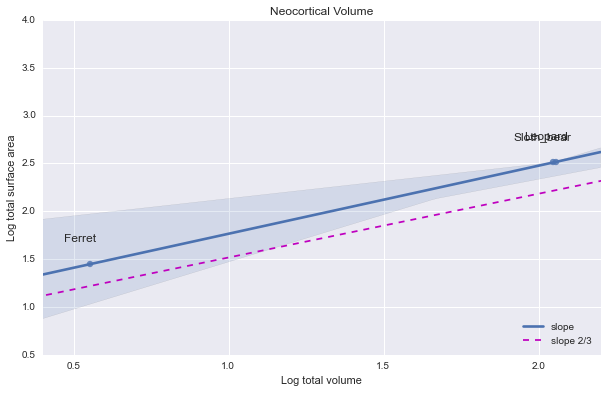

In [13]:
# plot data in allometric function

x = np.asarray(V_species)/1000 #convert to cm3
y = np.asarray(S_species)/100 #convert to cm2

## now for log10
for index, item in enumerate(y):
    y[index] = math.log10(item)
for index, item in enumerate(x):
    x[index] = math.log10(item)
    

fig = plt.figure()
fig.set_size_inches(10, 6)
ax = sns.regplot(x,y, scatter_kws={'s':40})
plt.title("Neocortical Volume")
plt.xlabel('Log total volume')
plt.ylabel('Log total surface area')
slope, intercept= np.polyfit(x,y,1)
print('slope = ' + str(slope))



for i in [0,1,2,3,5,6,7,8,9]:
    for xy in zip(x, y):
        ax.annotate('%s' % (species[i]), xy=xy, xytext=(-10,20), textcoords='offset points', ha='center', va='bottom')
        i=i+1
    break

    

# 2/3 slope
x1 = np.arange(0, 4, step=0.1)
y1 = (2./3.)*x1 + 0.85
a, b= np.polyfit(x1,y1,1)
plt.plot(x1, a*x1 + b, 'm--')
plt.legend(['slope' , 'slope 2/3'], loc=4)
#plt.savefig('allometry.png') #update with your path
plt.show()

In [14]:
# save the data to .csv and .txt 

V_species_cm = np.asarray(V_species)/1000 #convert to cm3
S_species_cm = np.asarray(S_species)/100 #convert to cm2

allinamatrix = np.matrix([V_species_cm, S_species_cm, F_species, nv_species, nt_species, X_species, Y_species, Z_species])
allinamatrix = allinamatrix.transpose()
names = ['Volume[cm3]', 'Surface area[cm2]', 'Absolute folding', 'N vertices', 'N triangles', 'X[mm]', 'Y[mm]', 'Z[mm]']
allinamatrix = pd.DataFrame(allinamatrix, index = species, columns=names)
print allinamatrix
#allinamatrix.to_csv('species_data.txt', index=True, header=True, sep=' ')
allinamatrix.to_csv('data.csv', index=True, header=True, sep=',')


            Volume[cm3]  Surface area[cm2]  Absolute folding  N vertices  \
Ferret         3.579842          28.021616          2.476090        9991   
Sloth_bear   111.387155         324.552870          2.898976        9996   
Leopard      113.513511         326.777497          2.882281        6949   

            N triangles      X[mm]      Y[mm]      Z[mm]  
Ferret            20000  31.720944  22.935833  -1.702805  
Sloth_bear        20000  66.575200  78.376400  19.499165  
Leopard           13978  71.691400  79.954300  12.044700  


In [15]:
# separate hemispheres using Laplace-beltrami eigenfunctions

import sys
import os
import platform


# Mindboogle

mindbog=os.path.join('mindboggle-master')
sys.path.append(mindbog)
sys.path.append(os.path.join(mindbog,'mindboggle/shapes'))

import laplace_beltrami as LB
import numpy
import scipy
import time


A,B=LB.computeAB(vertices, faces)
#A and B will be used to compute laplace beltrami eigenfunstions or fourier modes

import matplotlib.pylab as plt
#plt.spy(A)
#plt.show()
#the points have to be on the same line 


#points=numpy.array(p)
#faces=numpy.array(t, dtype = numpy.int_)

A,B=LB.computeAB(vertices, faces)
#A and B will be used to compute laplace beltrami eigenfunstions or fourier modes

#t=time.time()
ev,evec=LB.fem_laplacian(vertices, faces, 20)
#print time.time()-t

Compute linear FEM Laplace-Beltrami spectrum


In [17]:
x = vertices[:,0]
y = vertices[:,1]
z = vertices[:,2]

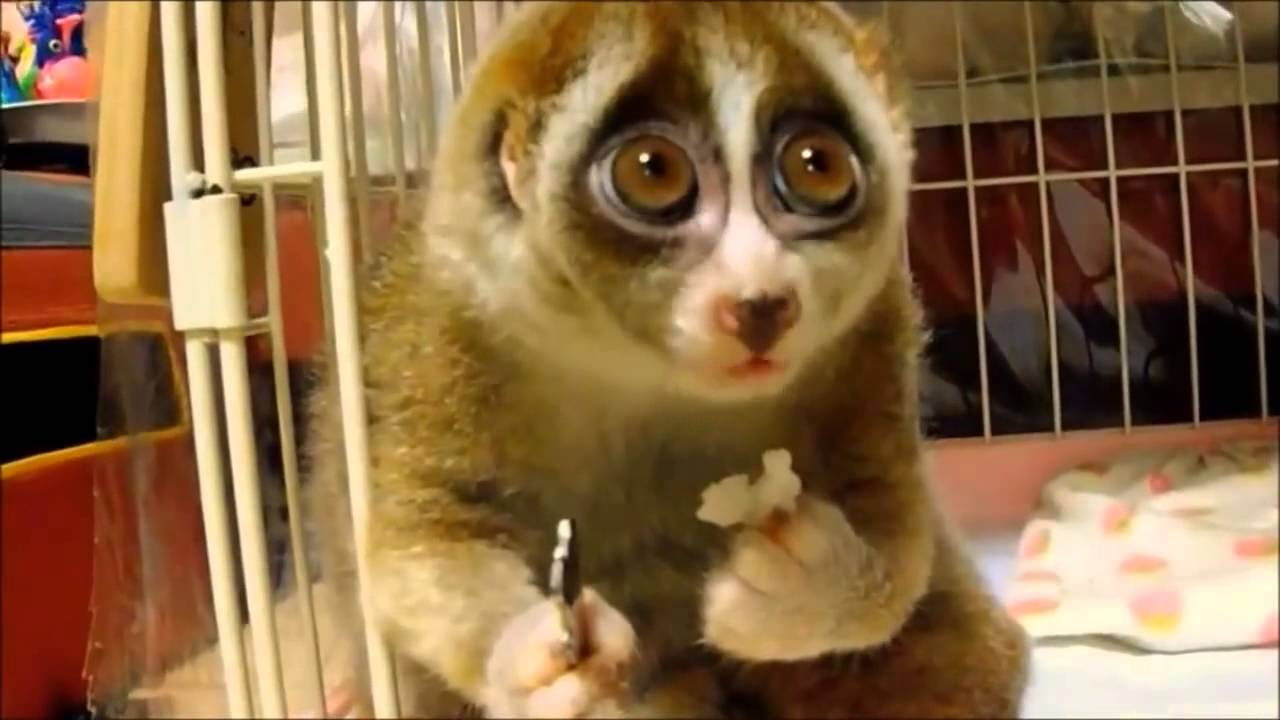

In [21]:
from IPython.display import Image
Image("https://i.ytimg.com/vi/VtDgfJjNU7w/maxresdefault.jpg")

In [19]:
data=plotly_trisurf(x,y,z, faces, evec[:, 1], plot_edges=None)
iplot(data)

In [20]:
import numpy
import scipy.sparse
 
def findNonManifoldEdges(v, f):
    e = scipy.sparse.dok_matrix((v.shape[0], v.shape[0]), dtype = numpy.int32)
 
    f_ = numpy.sort(f, axis = 1)
 
    e[f_[:, 0], f_[:, 1]] += 1
    e[f_[:, 1], f_[:, 2]] += 1
    e[f_[:, 0], f_[:, 2]] += 1
 
    nme = scipy.sparse.find(e > 2)
 
    return nme[0], nme[1]


 
def mergeIdenticalVertices(v, f):
    vr = numpy.around(v, decimals = 10)
    vrv = vr.view(v.dtype.descr * v.shape[1])
    _, idx, inv = numpy.unique(vrv, return_index = True, return_inverse = True)
 
    lkp = idx[inv]
 
    v_ = v[idx, :]
    f_ = numpy.asarray([[lkp[f[i, j]] for j in xrange(f.shape[1])] for i in xrange(f.shape[0])], dtype = numpy.int32)
 
    return v, f_
 
def removeNonManifoldTriangles(v, f):
    v_ = v[f]
    fn = numpy.cross(v_[:, 1] - v_[:, 0], v_[:, 2] - v_[:,0])
 
    f_ = f[numpy.logical_not(numpy.all(numpy.isclose(fn, 0), axis = 1)), :]
 
    return v, f_

In [21]:
nme = findNonManifoldEdges(vertices, faces)
print nme

v, f_ = mergeIdenticalVertices(vertices, faces)
print len(v)
print len(vertices)

v, f_ = removeNonManifoldTriangles(vertices, faces)


(array([1692, 2231, 2897, 3059, 3297, 3297, 3726, 4214, 4438], dtype=int32), array([1805, 2478, 2983, 3221, 3299, 3364, 3846, 4376, 4671], dtype=int32))
6949
6949
6949
6949
13978
13978


In [16]:
#is it faces instead of triangles????



def graph_from_mesh(nodes, triangles, node_coords=False, edge_length=False):
    '''
    Creates a networkx graph from a mesh
    '''
    
    import numpy as np
    import networkx as nx
    
    # initiate empty graph
    G=nx.Graph()
    
    # add node indices
    G.add_nodes_from(range(len(nodes)))
    
    # add edges
    G.add_edges_from(triangles[:,[0,1]])
    G.add_edges_from(triangles[:,[0,2]])
    G.add_edges_from(triangles[:,[1,2]])
    
    # caution! this adds a key 'coords' to the node
    # which will also be picked up by .neighbors methods
    
    if edge_length:
        for e in G.edges_iter():
            #G[e[0]][e[1]]['length']=np.linalg.norm(nodes[e[0]]-nodes[e[1]])
            G[e[0]][e[1]]=np.linalg.norm(nodes[e[0]]-nodes[e[1]])
            G[e[1]][e[0]]=np.linalg.norm(nodes[e[0]]-nodes[e[1]])
            
    if node_coords:
        for n in G.nodes_iter():
            G[n]['coords']=nodes[n]

    return G


def subcluster_graph(nodes, triangles, clustering):
    
    '''
    Finds the non-connected components of each cluster
    Currently works with networkx 1.6, not with 1.10
    '''
    
    import numpy as np
    import networkx as nx
    
    # initiate empty graph
    G=nx.Graph()
    
    # add node indices
    G.add_nodes_from(range(len(nodes)))
    
    # add edges
    G.add_edges_from(triangles[:,[0,1]])
    G.add_edges_from(triangles[:,[0,2]])
    G.add_edges_from(triangles[:,[1,2]])
        
        
    # make an array with one column per cluster
    # entries will be 0 if this node is not in the respective subcluster
    # otherwise they refer to the number of the sublcuster
    # therefore, the subclusters have to be one-indexed
    subclust_arr = np.zeros((clustering.shape[0], int(clustering.max()+1)))
    #for each cluster
    for nclust in range(int(clustering.max()+1)):
        # make a subgraph only containing nodes from this cluster
        clustgraph = nx.subgraph(G, np.where(clustering==nclust)[0])
        # find the seperate connected components of this subgraph
        subclust = nx.connected_components(clustgraph)
        
        for i in range(len(subclust)):
            for j in subclust[i]:
                subclust_arr[j][nclust] = i+1

    return subclust_arr

def node_cluster_id(node, subclustering):
    import numpy as np
    if np.where(subclustering[node]!=0)[0].shape[0] == 0:
        return None
    else:
        main_clust = int(np.where(subclustering[node]!=0)[0][0])
        sub_clust = int(subclustering[node][main_clust])
        clust_id = str(main_clust)+'_'+str(sub_clust)
        return clust_id


def adjacent_subcluster(nodes, triangles, subclustering):
    import numpy as np
    G = graph_from_mesh(nodes, triangles)
    
    unique_pairs=[]
    for e in G.edges():
        ca = node_cluster_id(e[0], subclustering)
        cb = node_cluster_id(e[1], subclustering)
        if (ca is not None and cb is not None and ca != cb):
            if (not (ca, cb) in unique_pairs and not (cb, ca) in unique_pairs):
                unique_pairs.append((ca, cb))
    
    return unique_pairs


def dijkstra(G, start, end=None):
    '''
    adapted to work with networkx graphs from:
    https://github.com/joyrexus/dijkstra/blob/master/dijkstra.py
    '''
    '''
    dijkstra's algorithm determines the length from `start` to every other 
    vertex in the graph.
    The graph argument `G` should be a dict indexed by nodes.  The value 
    of each item `G[v]` should also a dict indexed by successor nodes.
    In other words, for any node `v`, `G[v]` is itself a dict, indexed 
    by the successors of `v`.  For any directed edge `v -> w`, `G[v][w]` 
    is the length of the edge from `v` to `w`.
        graph = {'a': {'b': 1}, 
                 'b': {'c': 2, 'b': 5}, 
                 'c': {'d': 1},
                 'd': {}}
    Returns two dicts, `dist` and `pred`:
        dist, pred = dijkstra(graph, start='a') 
    
    `dist` is a dict mapping each node to its shortest distance from the
    specified starting node:
        assert dist == {'a': 0, 'c': 3, 'b': 1, 'd': 4}
    `pred` is a dict mapping each node to its predecessor node on the
    shortest path from the specified starting node:
        assert pred == {'b': 'a', 'c': 'b', 'd': 'c'}
    
    '''
    
    from pqdict import PQDict
    import networkx as nx
    
    inf = float('inf')
    D = {start: 0}          # mapping of nodes to their dist from start
    Q = PQDict(D)           # priority queue for tracking min shortest path
    P = {}                  # mapping of nodes to their direct predecessors
    #U = set(G.keys())       # unexplored nodes
    U = set(G.nodes())

    while U:                                    # nodes yet to explore
        (v, d) = Q.popitem()                    # node w/ min dist d on frontier
        D[v] = d                                # est dijkstra greedy score
        U.remove(v)                             # remove from unexplored
        if v == end: break

        # now consider the edges from v with an unexplored head -
        # we may need to update the dist of unexplored successors 
        for w in G[v]:                          # successors to v
            if w in U:                          # then w is a frontier node
                d = D[v] + G[v][w]              # dgs: dist of start -> v -> w
                if d < Q.get(w, inf):
                    Q[w] = d                    # set/update dgs
                    P[w] = v                    # set/update predecessor

    return D, P



def shortest_path(G, start, end):
    
    from pqdict import PQDict
    import networkx as nx
    
    dist, pred = dijkstra(G, start, end)
    v = end
    path = [v]
    while v != start:
        v = pred[v]
        path.append(v)        
    path.reverse()
    return path


def sorted_path(G, path):
    import networkx as nx
    subG = nx.subgraph(G, path)
    ends = []
    for node in path:
        if nx.degree(subG)[node] == 1:
            ends.append(node)
    sorted_path = shortest_path(subG, ends[0], ends[1])
    return sorted_path

In [56]:
#triangles = np.array(vertices[faces])
graph_from_mesh(vertices, faces, node_coords=False, edge_length=False)

### To Do:
- calculate Euler number (must be 2 = topologically spherical mesh) *DONE
- separate the hemispheres
- safe mesh and hemispheres in differet formats (.vtk, .stl, .ply)